# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Changing the code a bit to accommodate for multi-class case. This is a demo notebook.

## Imports

In [38]:
!pip install -U --pre tensorflow=="2.3.0"

Requirement already up-to-date: tensorflow==2.3.0 in /usr/local/lib/python3.6/dist-packages (2.3.0)


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2022, done.
remote: Counting objects: 100% (2022/2022), done.
remote: Compressing objects: 100% (1758/1758), done.
remote: Total 2022 (delta 463), reused 862 (delta 241), pack-reused 0
Receiving objects: 100% (2022/2022), 30.20 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (463/463), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1559390 sha256=1b64299e119155099497895e5cf76cb44122817c7d509dd7b0d981229c483272
  Stored in directory: /tmp/pip-ephem-wheel-cache-guar1632/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.0-cp36-none-any.whl size=43735 sha256=09de0fabf3c2b2282077630d038e1faab1e3438a02aade08f028ac7bcd364d60
  Stored in directory: /root/.cache/pip/wheels/3f/15/cd/fe4ec8b88c130393464703ee8111e2cddebdc40e1b59ea85e9
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78532 sha256=12b4f0c0b63a3cddf17289151e0d9430cf02d9e342797135cf4240f45f0bdaf9
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=125a9f18ec0a401af80b984627c475cdf14986c9a2b8dd20f969916b6b

ERROR: pydrive 1.3.1 has requirement oauth2client>=4.0.0, but you'll have oauth2client 3.0.0 which is incompatible.
ERROR: multiprocess 0.70.10 has requirement dill>=0.3.2, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: apache-beam 2.23.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [71]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8), image.size

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    min_score_thresh=0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=min_score_thresh)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Food data

We will start with some toy (literally) data consisting of 5 images of 3 different food categories.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain these food, so the classes are noval.

In [6]:
# create train and test folder, if needed
from pathlib import Path

Path('/content/food_train').mkdir(exist_ok=True)
Path('/content/food_test').mkdir(exist_ok=True) 

In [7]:
!ls -A /content

.config  food_test  food_train	models	sample_data


Need to upload:

* zip archive containing actual images
* ground truth labels (a csv file with two columns for each file: filename and ground truth label)
* bounding boxes information: output from the simple annotation tool.

In [8]:
# upload the zip file, ground truth labels, and bounding boxes
from google.colab import files

uploaded = files.upload()

Saving extracted_top30.zip to extracted_top30.zip
Saving food_samples_ground_truth_labels.csv to food_samples_ground_truth_labels.csv
Saving out.csv to out.csv


In [9]:
import pandas as pd

gt_labels = pd.read_csv('food_samples_ground_truth_labels.csv', header=None)
gt_labels.columns =['filename', 'gt_label'] 
gt_labels.head()

,filename,gt_label
0,baby_back_ribs_1034506.jpg,Baby back ribs
1,baby_back_ribs_1022479.jpg,Baby back ribs
2,baby_back_ribs_1031112.jpg,Baby back ribs
3,baby_back_ribs_1005066.jpg,Baby back ribs
4,baby_back_ribs_1009028.jpg,Baby back ribs


In [10]:
gt_label_orig_distinct = gt_labels['gt_label'].drop_duplicates().values.tolist()
gt_label_transformed = ['_'.join(x.split(' ')).lower() for x in gt_label_orig_distinct]
gt_label_transformed

['baby_back_ribs', 'baklava', 'apple_pie']

In [11]:
from zipfile import ZipFile

def extract_pic_per_class_train_test(archive_name, similar_to_path, train_dir, test_dir):
  with ZipFile(archive_name, 'r') as zipObj:
    listOfiles = zipObj.namelist()
    matches = [x for x in listOfiles if similar_to_path in x]
    for i in range(len(matches)):
      if i < len(matches) / 2:
        zipObj.extract(member=matches[i], path=train_dir)
      else:
        zipObj.extract(member=matches[i], path=test_dir)

In [12]:
for formatted_class in gt_label_transformed:
  print("Extracting pic for {}.".format(formatted_class))
  extract_pic_per_class_train_test('extracted_top30.zip', formatted_class, '/content/food_train', '/content/food_test')

Extracting pic for baby_back_ribs.
Extracting pic for baklava.
Extracting pic for apple_pie.


## Load Train Food Images

WIP - need to figure out a way to get the loaded images to match with filenames. Currently seems to be everywhere

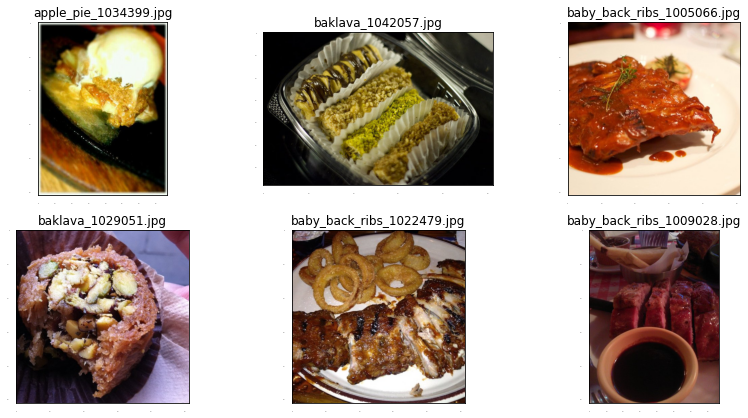

In [13]:
# Load images and visualize
train_image_dir = '/content/food_train'
train_images_np = {}
img_size = {}

for (dirpath, dirnames, filenames) in os.walk(train_image_dir):
  for f in filenames:
    image_path = os.path.join(dirpath, f)
    train_images_np[f], img_size[f] = load_image_into_numpy_array(image_path)

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

random_6_keys = random.sample(train_images_np.keys(), 6)

for idx, key in enumerate(random_6_keys):
  plt.subplot(2, 3, idx+1)
  plt.title(key)
  plt.imshow(train_images_np[key])
plt.show()

# Annotate images with bounding boxes

In this cell you will annotate images in the train directory --- draw a box around the food object in each image; click `next image` to go to the next image and `submit` when there are no more images.

Manual annotation should not be needed as it has already been handled in another app. However, leaving the code here for future reference.



In [ ]:
# uncomment to manually draw bouding boxes
# gt_boxes = []
# colab_utils.annotate(train_images_np.values(), box_storage_pointer=gt_boxes)

# Get bounding boxes for each train images

Since we already have bounding boxes drawn, we will just load it up.

In [14]:
def normalize_coordinates(image_size, xmin, xmax, ymin, ymax):
  new_xmin = xmin / image_size[0]
  new_xmax = xmax / image_size[0]
  new_ymin = ymin / image_size[1]
  new_ymax = ymax / image_size[1]

  return (new_ymin, new_xmin, new_ymax, new_xmax)

In [15]:
gt_boxes = {}

bounding_boxes_all = pd.read_csv('out.csv')

In [16]:
bounding_boxes_all[bounding_boxes_all['image'].isin(img_size.keys())]

,image,id,name,xMin,xMax,yMin,yMax
0,apple_pie_1005649.jpg,1,Apple pie,0.345454,304.000000,50.943161,463.679077
2,apple_pie_101251.jpg,1,Apple pie,0.000000,303.936526,21.654140,512.000000
3,apple_pie_1014775.jpg,1,Apple pie,273.331853,508.590455,151.724750,483.587125
6,apple_pie_1034399.jpg,1,Apple pie,20.031077,361.411765,11.084097,364.496253
8,apple_pie_1038694.jpg,1,Apple pie,96.035516,435.853496,80.671096,240.877076
10,baby_back_ribs_1005066.jpg,1,Baby back ribs,3.420441,448.805573,92.379105,421.367493
15,baby_back_ribs_1009028.jpg,1,Baby back ribs,39.767501,374.609276,134.263000,416.589478
16,baby_back_ribs_1022479.jpg,1,Baby back ribs,4.000000,507.000000,231.000000,439.000000
18,baby_back_ribs_1031112.jpg,1,Baby back ribs,0.000000,276.052292,86.352509,371.691925
19,baby_back_ribs_1034506.jpg,1,Baby back ribs,13.724454,494.490631,123.488571,416.767029


In [17]:
for index, row in bounding_boxes_all.iterrows():
  if row['image'] in img_size: # only want to get training images only
    label_array = np.asarray(normalize_coordinates(img_size[row['image']],
                                                      row['xMin'], row['xMax'], 
                                                      row['yMin'], row['yMax']), dtype=np.float32)
    if row['image'] in gt_boxes:
      gt_boxes[row['image']] = np.append(gt_boxes[row['image']], label_array, axis=0)
    else:
      gt_boxes[row['image']] = np.asarray([label_array])

In [18]:
gt_boxes

{'apple_pie_1005649.jpg': array([[0.09949836, 0.0011216 , 0.9056232 , 0.987013  ]], dtype=float32),
 'apple_pie_101251.jpg': array([[0.04229324, 0.        , 1.        , 0.79150134]], dtype=float32),
 'apple_pie_1014775.jpg': array([[0.2963374 , 0.53385127, 0.9445061 , 0.99334073]], dtype=float32),
 'apple_pie_1034399.jpg': array([[0.02164863, 0.05216426, 0.71190673, 0.9411765 ]], dtype=float32),
 'apple_pie_1038694.jpg': array([[0.2358804 , 0.18756936, 0.70431894, 0.85127634]], dtype=float32),
 'baby_back_ribs_1005066.jpg': array([[0.18042794, 0.00668055, 0.8229834 , 0.8765734 ]], dtype=float32),
 'baby_back_ribs_1009028.jpg': array([[0.26223242, 0.1035612 , 0.8136513 , 0.975545  ]], dtype=float32),
 'baby_back_ribs_1022479.jpg': array([[0.45117188, 0.0078125 , 0.8574219 , 0.9902344 ]], dtype=float32),
 'baby_back_ribs_1031112.jpg': array([[0.16865724, 0.        , 0.7259608 , 0.90806675]], dtype=float32),
 'baby_back_ribs_1034506.jpg': array([[0.24118862, 0.02680557, 0.8139981 , 0.9658

In [ ]:
# old code
# gt_boxes = [
#             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
#             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#             np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#             np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#             np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
# ]

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [19]:
# By convention, our non-background classes start counting at 1.
category_index = {}
num_classes = len(gt_label_orig_distinct)

for i in range(1,num_classes+1):
  temp_dict = {}
  temp_dict['id'] = i
  temp_dict['name'] = gt_label_orig_distinct[i-1]
  category_index[i] = temp_dict

category_index

{1: {'id': 1, 'name': 'Baby back ribs'},
 2: {'id': 2, 'name': 'Baklava'},
 3: {'id': 3, 'name': 'Apple pie'}}

Helper function below to get the correct class for a bounding box

In [20]:
def get_category_id_by_filename(filename, ground_truth_df):
  ground_truth_label = ground_truth_df[ground_truth_df['image'] == filename]['name'].values[0]
  return [k for k, v in category_index.items() if v['name'] == ground_truth_label]

In [21]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = {}
gt_classes_one_hot_tensors = {}
gt_box_tensors = {}

for key in train_images_np.keys():
  train_image_tensors[key] = tf.expand_dims(tf.convert_to_tensor(
      train_images_np[key], dtype=tf.float32), axis=0)
  gt_box_tensors[key] = tf.convert_to_tensor(gt_boxes[key], dtype=tf.float32)
  # zero_indexed_groundtruth_classes = tf.convert_to_tensor(
  #     np.ones(shape=[gt_boxes[key].shape[0]], dtype=np.int32) - label_id_offset)
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.asarray(get_category_id_by_filename(key, bounding_boxes_all)) - label_id_offset)
  gt_classes_one_hot_tensors[key] = tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes)
  
print('Done prepping data.')

Done prepping data.


# Let's just visualize the food images as a sanity check


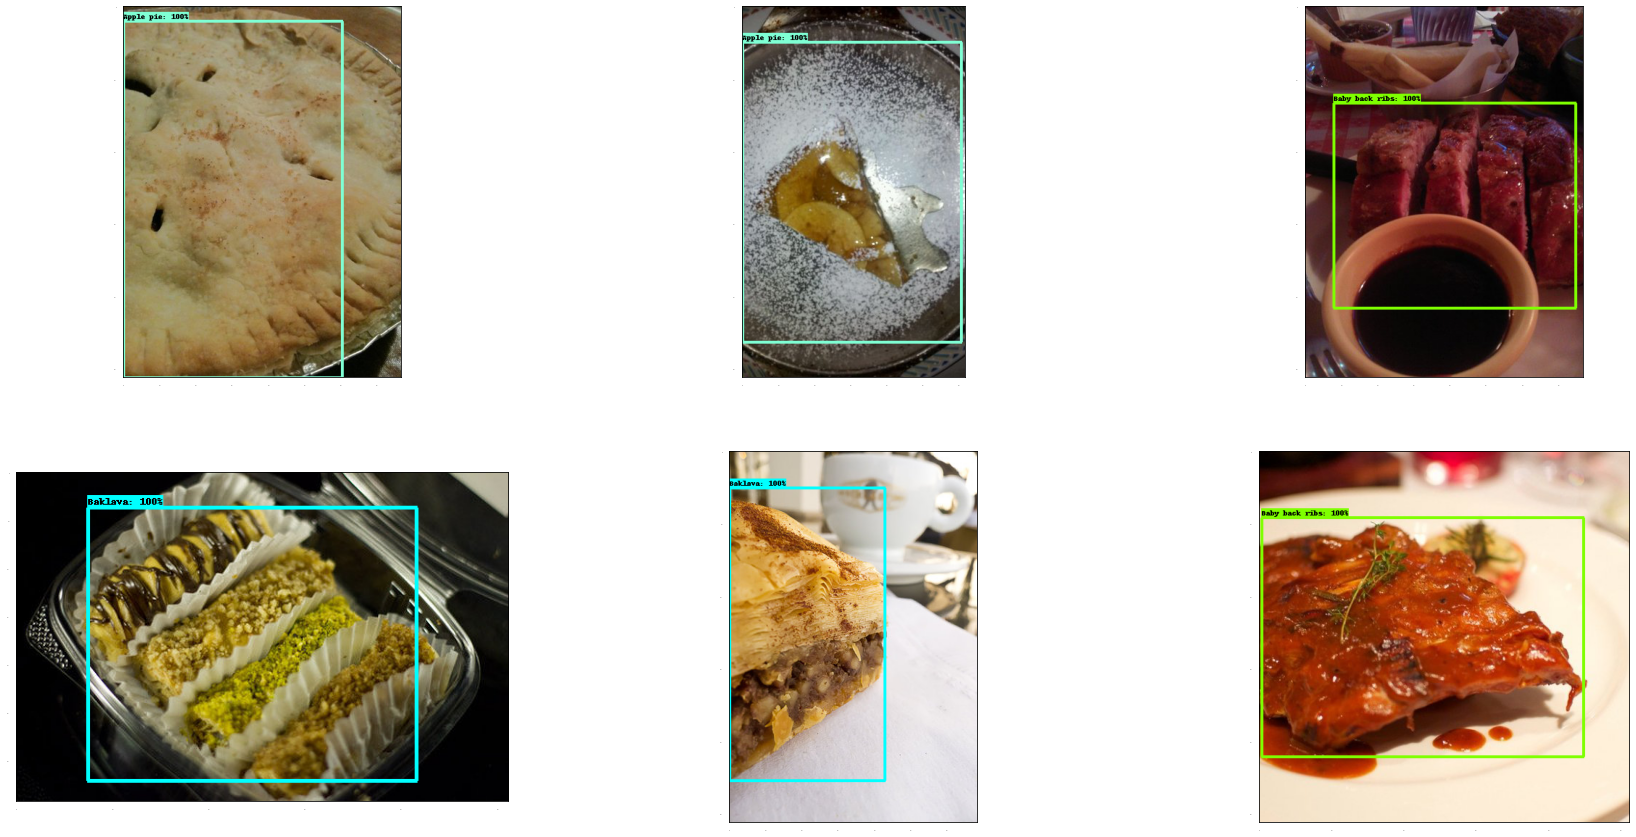

In [22]:
random_6_keys = random.sample(train_images_np.keys(), 6)

plt.figure(figsize=(30, 15))
for idx, key in enumerate(random_6_keys):
  dummy_scores = np.ones(shape=[gt_boxes[key].shape[0]], dtype=np.int32)
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[key],
      gt_boxes[key],
      np.asarray(get_category_id_by_filename(key, bounding_boxes_all)),
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [50]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-09-02 18:22:51--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.79.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  73.9MB/s    in 3.2s    

2020-09-02 18:22:54 (73.9 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [51]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = len(gt_label_orig_distinct)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [52]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

Actual fine-tuning: see below.

You may see messages such as `WARNING:tensorflow:10 out of the last 11 calls to <function get_model_train_step_function.<locals>.train_step_fn at 0x7f536a91eb70> triggered tf.function retracing...` Looks like this is a known issue with TF 2.0 when inputs are in various lengths. If comment out the `@tf.function` decorater above (right near `def train_step_fn`) this issue seems to go away.

In [53]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_func = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(train_images_np.keys())
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_func(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.2703457
batch 10 of 100, loss=0.46205154
batch 20 of 100, loss=0.47942793
batch 30 of 100, loss=0.20149834
batch 40 of 100, loss=0.12700325
batch 50 of 100, loss=0.17991391
batch 60 of 100, loss=0.08547871
batch 70 of 100, loss=0.11476149
batch 80 of 100, loss=0.08139902
batch 90 of 100, loss=0.07545253
Done fine-tuning!


# Load test images and run inference with new model!

In [54]:
test_image_dir = '/content/food_test'
test_images_np = {}

for (dirpath, dirnames, filenames) in os.walk(test_image_dir):
  for f in filenames:
    image_path = os.path.join(dirpath, f)
    test_images_np[f], img_size[f] = load_image_into_numpy_array(image_path)

# for i in range(1, 50):
#   image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
#   test_images_np.append(np.expand_dims(
#       load_image_into_numpy_array(image_path), axis=0))

In [55]:
test_images_np.keys()

dict_keys(['apple_pie_1026328.jpg', 'apple_pie_1011328.jpg', 'baby_back_ribs_1007102.jpg', 'baklava_1024334.jpg', 'apple_pie_103801.jpg', 'baby_back_ribs_1005293.jpg', 'baklava_1014880.jpg', 'baby_back_ribs_1031072.jpg', 'baklava_1021344.jpg', 'apple_pie_1043283.jpg', 'baby_back_ribs_1008749.jpg', 'baby_back_ribs_1007272.jpg', 'apple_pie_1028787.jpg', 'baklava_1028777.jpg', 'baklava_1006121.jpg'])

In [56]:
# Again, uncomment this decorator if you want to run inference eagerly
#@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

In [59]:
test_images_np['apple_pie_1026328.jpg'].shape

(512, 512, 3)

Show one image

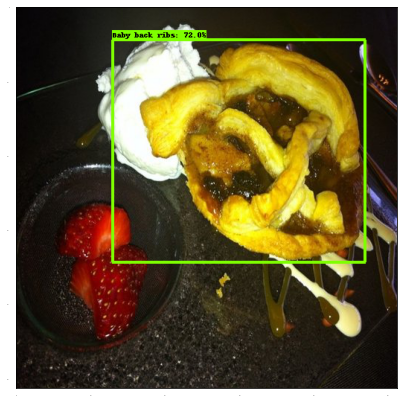

In [84]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
key_selected = 'apple_pie_1026328.jpg'

input_tensor = tf.convert_to_tensor(np.asarray([test_images_np[key_selected]]), dtype=tf.float32)
detections = detect(input_tensor)

plot_detections(
    test_images_np[key_selected],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index, figsize=(15, 20), image_name=None,
    min_score_thresh=0.5)

Show images for the whole test set

Note: if change `image_name` parameter for the `plot_detections` function, will save in the current container instead.

In [91]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for key in test_images_np.keys():
  input_tensor = tf.convert_to_tensor(np.asarray([test_images_np[key]]), dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[key],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name=key,
      min_score_thresh=0.5)
  plt.show()

Result is not too encouraging! But this is how eager few shot training works with TF.